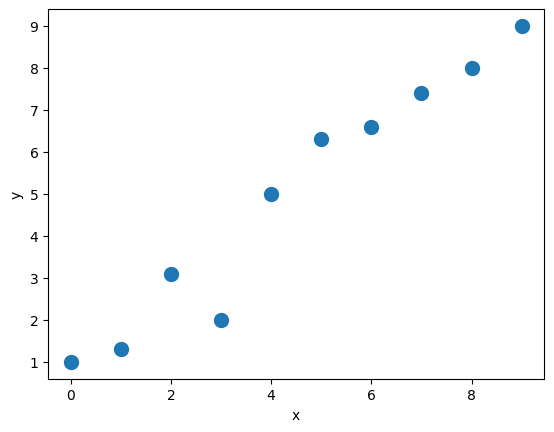

In [13]:
import numpy as np
import matplotlib.pyplot as plt


X_train = np.arange(10, dtype = 'float32')
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0] , dtype='float32')
plt.plot(X_train, y_train,'o', markersize = 10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [14]:
from torch.utils.data import TensorDataset, DataLoader

import torch

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train)
train_ds = TensorDataset(X_train_norm, y_train)
batch_size = 1
train_dl = DataLoader(train_ds,batch_size=batch_size, shuffle= True)


In [15]:
torch.manual_seed(1)
weight = torch.randn(1)
weight.requires_grad_()
bias = torch.zeros(1, requires_grad = True)
def model(xb):
    return xb @ weight + bias

def loss_fn(input, target):
    return (input - target).pow(2).mean()

lr = 0.001
epochs = 200
log_epochs = 10
for epoch in range(epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
    with torch.no_grad():
        weight -= weight.grad * lr
        bias -= bias.grad*lr
        weight.grad.zero_()
        bias.grad.zero_()
    if epoch % log_epochs == 0:
        print(f"epoch : {epoch} Loss : {loss.item():.4f}")

epoch : 0 Loss : 41.2725
epoch : 10 Loss : 24.4285
epoch : 20 Loss : 1.0575
epoch : 30 Loss : 15.1630
epoch : 40 Loss : 12.5989
epoch : 50 Loss : 5.0840
epoch : 60 Loss : 0.7865
epoch : 70 Loss : 3.7489
epoch : 80 Loss : 2.4036
epoch : 90 Loss : 0.4430
epoch : 100 Loss : 1.1155
epoch : 110 Loss : 1.3195
epoch : 120 Loss : 0.1064
epoch : 130 Loss : 0.5676
epoch : 140 Loss : 0.2216
epoch : 150 Loss : 1.4862
epoch : 160 Loss : 0.0483
epoch : 170 Loss : 0.0061
epoch : 180 Loss : 0.0016
epoch : 190 Loss : 0.0294


In [1]:
print('parameter : ', weight.item(0, bias.item()))

NameError: name 'weight' is not defined

#### 붓꽃 데이터셋 분류

In [22]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn

iris = load_iris()
X = iris['data']
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 1./3, random_state = 1)
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)
train_ds = TensorDataset(X_train_norm, y_train)
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [31]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size,output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
model = Model(input_size, hidden_size, output_size)

lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =lr)

In [32]:
epochs = 100
loss_hist = [0]*epochs
accuracy_hist = [0]*epochs

for epoch in range(epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim = 1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
    loss_hist[epoch] /=len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

In [34]:
import matplotlib.pyplot as plt

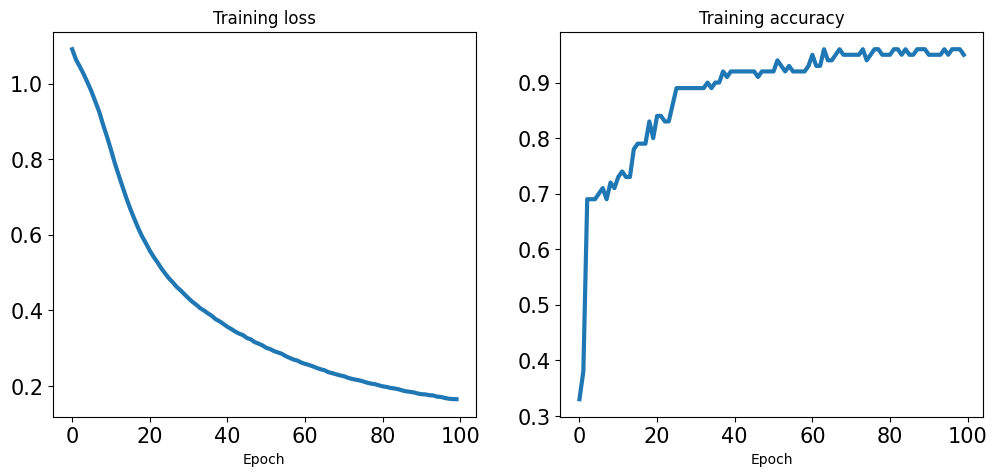

In [36]:

fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(loss_hist,lw = 3)
ax.set_xlabel('Epoch')
ax.set_title('Training loss')
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax = fig.add_subplot(1,2,2)
ax.plot(accuracy_hist,lw=3)
ax.set_title('Training accuracy')
ax.set_xlabel('Epoch')
ax.tick_params(axis='both', which = 'major', labelsize = 15)
plt.show()


In [37]:
X_test_norm = (X_test - np.mean(X_train))/np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim = 1) == y_test).float()
accuracy = correct.mean()
print(f'테스트 정확도 : {accuracy:.3f}')

테스트 정확도 : 0.980


In [39]:
path = 'model/iris_classifier.pt'
torch.save(model, path)

In [41]:
model_new = torch.load(path)
model_new.eval()
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim = 1) == y_test).float()
accuracy = correct.mean()
print(f'테스트 정확도 : {accuracy:.3f}')

테스트 정확도 : 0.980


In [44]:
path = 'model/iris_state.pt'
torch.save(model.state_dict(), path)
model_new2 = Model(input_size, hidden_size, output_size)
model_new2.load_state_dict(torch.load(path))

<All keys matched successfully>

#### 12.5 활성화 함수의 선택

AttributeError: module 'torch.mps' has no attribute 'device_count'